# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2  
%autosave 10

Autosaving every 10 seconds


In [2]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from PIL import Image
import random, os, sys, argparse
from pathlib import Path
from tqdm import tqdm
import pickle
from PIL import Image

In [3]:
sys.path.insert(0,'/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/scripts')
from models import *

# Train Model

In [4]:
# user hyperparams
model = 'resnet18' # resnet18, vgg16, densenet121
train_csv = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_svhn_bot_fmnist_2class_ro_1p0.csv'
test_csv = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_blank_bot_fmnist_2class_ro_1p0.csv'
expt_name = f'temp_{int(random.random()*100000)}'# f'resnet18_top_mnist_bot_kmnist_{int(random.random()*100000)}'
save_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/output/'

num_epochs = 50
lr = 0.1
seed = 10
num_ch = 3 # num of channels in image
num_embs = 2000 # 1500 for mnist, 10k for cifar10
K = 29 # K neighbours
num_test_imgs = 20 # num of test images for plotting PD
lp_norm = 1 # for computing KNN
knn_pos_thresh = 0.5
knn_neg_thresh = 0.5

In [5]:
# Setting the seed
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv).sample(500)

In [7]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, class_field, transform, csv_path=None, df=None):
        self.class_field = class_field        
        self.transform = transform
        if df is not None:
            self.df = df
        else:
            self.csvpath = csvpath
            self.df = pd.read_csv(self.csvpath)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = str(self.df.iloc[idx]["path"])
        lab = int(self.df.iloc[idx][self.class_field])
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)  

        return {"img":img, "lab":lab, "idx":idx, "file_name" : img_path}

In [8]:
trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64,32)),
])
trainset = ToyDataset(class_field=['bottom'], transform=trans, df=df_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
testset = ToyDataset(class_field=['bottom'], transform=trans, df=df_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=2)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy


# Model
print('==> Building model..')
if model=='resnet18':
    net = ResNet18(num_channels=num_ch)
elif model=='vgg16':
    net = VGG('VGG16',num_channels=num_ch)
elif model=='densenet121':
    net = DenseNet121()
net.linear = nn.Linear(in_features=1024,out_features=10,bias=True)
net = net.to(device)
    
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, batch in enumerate(tqdm(trainloader)):
        inputs = batch['img']
        targets = batch['lab']
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(testloader)):
            inputs = batch['img']
            targets = batch['lab']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
#     if acc > best_acc:
#         print('Saving..')
#         state = {
#             'net': net.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#         }
# #         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
# #             os.mkdir('checkpoint')
#         torch.save(state, os.path.join(save_dir,f'{expt_name}_ep{epoch}.pt'))
#         best_acc = acc
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    torch.save(state, os.path.join(save_dir,f'{expt_name}.pt'))


for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

==> Building model..

Epoch: 0


100%|██████████| 38/38 [03:50<00:00,  6.08s/it]


37 38 Loss: 2.503 | Acc: 81.792% (7852/9600)


100%|██████████| 2/2 [00:11<00:00,  5.59s/it]


1 2 Loss: 6.535 | Acc: 59.200% (296/500)
Saving..

Epoch: 1


100%|██████████| 38/38 [00:06<00:00,  5.74it/s]


37 38 Loss: 0.130 | Acc: 96.031% (9219/9600)


100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


1 2 Loss: 0.146 | Acc: 95.200% (476/500)
Saving..

Epoch: 2


100%|██████████| 38/38 [00:06<00:00,  5.82it/s]


37 38 Loss: 0.095 | Acc: 96.896% (9302/9600)


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


1 2 Loss: 0.093 | Acc: 96.200% (481/500)
Saving..

Epoch: 3


100%|██████████| 38/38 [00:06<00:00,  5.88it/s]


37 38 Loss: 0.076 | Acc: 97.427% (9353/9600)


100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


1 2 Loss: 0.072 | Acc: 97.800% (489/500)
Saving..

Epoch: 4


100%|██████████| 38/38 [00:06<00:00,  5.84it/s]


37 38 Loss: 0.067 | Acc: 97.688% (9378/9600)


100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


1 2 Loss: 0.065 | Acc: 98.200% (491/500)
Saving..

Epoch: 5


100%|██████████| 38/38 [00:06<00:00,  5.94it/s]


37 38 Loss: 0.057 | Acc: 98.031% (9411/9600)


100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


1 2 Loss: 0.059 | Acc: 98.000% (490/500)
Saving..

Epoch: 6


100%|██████████| 38/38 [00:06<00:00,  5.92it/s]


37 38 Loss: 0.054 | Acc: 98.312% (9438/9600)


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


1 2 Loss: 0.064 | Acc: 98.000% (490/500)
Saving..

Epoch: 7


100%|██████████| 38/38 [00:06<00:00,  5.88it/s]


37 38 Loss: 0.054 | Acc: 98.156% (9423/9600)


100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


1 2 Loss: 0.066 | Acc: 97.600% (488/500)
Saving..

Epoch: 8


100%|██████████| 38/38 [00:06<00:00,  5.93it/s]


37 38 Loss: 0.045 | Acc: 98.448% (9451/9600)


100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


1 2 Loss: 0.056 | Acc: 98.400% (492/500)
Saving..

Epoch: 9


100%|██████████| 38/38 [00:06<00:00,  5.95it/s]


37 38 Loss: 0.042 | Acc: 98.573% (9463/9600)


100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


1 2 Loss: 0.053 | Acc: 98.400% (492/500)
Saving..

Epoch: 10


100%|██████████| 38/38 [00:06<00:00,  5.79it/s]


37 38 Loss: 0.036 | Acc: 98.812% (9486/9600)


100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


1 2 Loss: 0.048 | Acc: 98.400% (492/500)
Saving..

Epoch: 11


100%|██████████| 38/38 [00:06<00:00,  5.85it/s]


37 38 Loss: 0.033 | Acc: 98.917% (9496/9600)


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


1 2 Loss: 0.061 | Acc: 98.000% (490/500)
Saving..

Epoch: 12


100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


37 38 Loss: 0.030 | Acc: 99.021% (9506/9600)


100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


1 2 Loss: 0.054 | Acc: 98.400% (492/500)
Saving..

Epoch: 13


100%|██████████| 38/38 [00:06<00:00,  5.82it/s]


37 38 Loss: 0.030 | Acc: 98.979% (9502/9600)


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


1 2 Loss: 0.036 | Acc: 98.800% (494/500)
Saving..

Epoch: 14


100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


37 38 Loss: 0.027 | Acc: 99.083% (9512/9600)


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


1 2 Loss: 0.040 | Acc: 98.000% (490/500)
Saving..

Epoch: 15


100%|██████████| 38/38 [00:06<00:00,  5.83it/s]


37 38 Loss: 0.023 | Acc: 99.198% (9523/9600)


100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


1 2 Loss: 0.046 | Acc: 98.200% (491/500)
Saving..

Epoch: 16


100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


37 38 Loss: 0.023 | Acc: 99.146% (9518/9600)


100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


1 2 Loss: 0.050 | Acc: 98.600% (493/500)
Saving..

Epoch: 17


100%|██████████| 38/38 [00:06<00:00,  5.90it/s]


37 38 Loss: 0.021 | Acc: 99.323% (9535/9600)


100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


1 2 Loss: 0.034 | Acc: 98.800% (494/500)
Saving..

Epoch: 18


100%|██████████| 38/38 [00:06<00:00,  5.90it/s]


37 38 Loss: 0.019 | Acc: 99.292% (9532/9600)


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


1 2 Loss: 0.038 | Acc: 98.600% (493/500)
Saving..

Epoch: 19


100%|██████████| 38/38 [00:06<00:00,  5.81it/s]


37 38 Loss: 0.017 | Acc: 99.448% (9547/9600)


100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


1 2 Loss: 0.034 | Acc: 98.400% (492/500)
Saving..

Epoch: 20


100%|██████████| 38/38 [00:06<00:00,  6.00it/s]


37 38 Loss: 0.015 | Acc: 99.490% (9551/9600)


100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


1 2 Loss: 0.024 | Acc: 99.400% (497/500)
Saving..

Epoch: 21


100%|██████████| 38/38 [00:06<00:00,  5.93it/s]


37 38 Loss: 0.014 | Acc: 99.510% (9553/9600)


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


1 2 Loss: 0.016 | Acc: 99.200% (496/500)
Saving..

Epoch: 22


100%|██████████| 38/38 [00:06<00:00,  5.93it/s]


37 38 Loss: 0.015 | Acc: 99.469% (9549/9600)


100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


1 2 Loss: 0.021 | Acc: 99.400% (497/500)
Saving..

Epoch: 23


100%|██████████| 38/38 [00:06<00:00,  5.93it/s]


37 38 Loss: 0.014 | Acc: 99.521% (9554/9600)


100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


1 2 Loss: 0.031 | Acc: 98.600% (493/500)
Saving..

Epoch: 24


100%|██████████| 38/38 [00:06<00:00,  5.94it/s]


37 38 Loss: 0.013 | Acc: 99.500% (9552/9600)


100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


1 2 Loss: 0.018 | Acc: 99.200% (496/500)
Saving..

Epoch: 25


100%|██████████| 38/38 [00:06<00:00,  5.83it/s]


37 38 Loss: 0.011 | Acc: 99.667% (9568/9600)


100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


1 2 Loss: 0.015 | Acc: 99.400% (497/500)
Saving..

Epoch: 26


100%|██████████| 38/38 [00:06<00:00,  5.94it/s]


37 38 Loss: 0.010 | Acc: 99.688% (9570/9600)


100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


1 2 Loss: 0.029 | Acc: 98.800% (494/500)
Saving..

Epoch: 27


100%|██████████| 38/38 [00:06<00:00,  5.74it/s]


37 38 Loss: 0.010 | Acc: 99.646% (9566/9600)


100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


1 2 Loss: 0.023 | Acc: 99.200% (496/500)
Saving..

Epoch: 28


100%|██████████| 38/38 [00:06<00:00,  5.97it/s]


37 38 Loss: 0.012 | Acc: 99.604% (9562/9600)


100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


1 2 Loss: 0.016 | Acc: 99.600% (498/500)
Saving..

Epoch: 29


100%|██████████| 38/38 [00:06<00:00,  6.04it/s]


37 38 Loss: 0.007 | Acc: 99.802% (9581/9600)


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


1 2 Loss: 0.011 | Acc: 99.800% (499/500)
Saving..

Epoch: 30


100%|██████████| 38/38 [00:06<00:00,  5.83it/s]


37 38 Loss: 0.008 | Acc: 99.729% (9574/9600)


100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


1 2 Loss: 0.012 | Acc: 99.600% (498/500)
Saving..

Epoch: 31


100%|██████████| 38/38 [00:06<00:00,  5.96it/s]


37 38 Loss: 0.008 | Acc: 99.719% (9573/9600)


100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


1 2 Loss: 0.011 | Acc: 99.800% (499/500)
Saving..

Epoch: 32


100%|██████████| 38/38 [00:06<00:00,  6.02it/s]


37 38 Loss: 0.006 | Acc: 99.844% (9585/9600)


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


1 2 Loss: 0.011 | Acc: 99.600% (498/500)
Saving..

Epoch: 33


100%|██████████| 38/38 [00:06<00:00,  5.95it/s]


37 38 Loss: 0.005 | Acc: 99.812% (9582/9600)


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


1 2 Loss: 0.016 | Acc: 99.600% (498/500)
Saving..

Epoch: 34


100%|██████████| 38/38 [00:06<00:00,  5.95it/s]


37 38 Loss: 0.007 | Acc: 99.792% (9580/9600)


100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


1 2 Loss: 0.013 | Acc: 99.800% (499/500)
Saving..

Epoch: 35


100%|██████████| 38/38 [00:06<00:00,  5.87it/s]


37 38 Loss: 0.005 | Acc: 99.854% (9586/9600)


100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


1 2 Loss: 0.008 | Acc: 99.800% (499/500)
Saving..

Epoch: 36


100%|██████████| 38/38 [00:06<00:00,  5.56it/s]


37 38 Loss: 0.004 | Acc: 99.906% (9591/9600)


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


1 2 Loss: 0.014 | Acc: 99.800% (499/500)
Saving..

Epoch: 37


100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


37 38 Loss: 0.004 | Acc: 99.917% (9592/9600)


100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


1 2 Loss: 0.008 | Acc: 99.800% (499/500)
Saving..

Epoch: 38


100%|██████████| 38/38 [00:06<00:00,  5.89it/s]


37 38 Loss: 0.003 | Acc: 99.958% (9596/9600)


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


1 2 Loss: 0.012 | Acc: 99.800% (499/500)
Saving..

Epoch: 39


100%|██████████| 38/38 [00:06<00:00,  6.02it/s]


37 38 Loss: 0.005 | Acc: 99.844% (9585/9600)


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


1 2 Loss: 0.014 | Acc: 99.600% (498/500)
Saving..

Epoch: 40


100%|██████████| 38/38 [00:06<00:00,  5.86it/s]


37 38 Loss: 0.007 | Acc: 99.760% (9577/9600)


100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


1 2 Loss: 0.009 | Acc: 99.800% (499/500)
Saving..

Epoch: 41


100%|██████████| 38/38 [00:06<00:00,  5.99it/s]


37 38 Loss: 0.004 | Acc: 99.865% (9587/9600)


100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


1 2 Loss: 0.007 | Acc: 100.000% (500/500)
Saving..

Epoch: 42


100%|██████████| 38/38 [00:06<00:00,  5.98it/s]


37 38 Loss: 0.005 | Acc: 99.781% (9579/9600)


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


1 2 Loss: 0.009 | Acc: 99.800% (499/500)
Saving..

Epoch: 43


100%|██████████| 38/38 [00:06<00:00,  5.98it/s]


37 38 Loss: 0.004 | Acc: 99.875% (9588/9600)


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


1 2 Loss: 0.016 | Acc: 99.200% (496/500)
Saving..

Epoch: 44


100%|██████████| 38/38 [00:06<00:00,  5.88it/s]


37 38 Loss: 0.007 | Acc: 99.792% (9580/9600)


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


1 2 Loss: 0.013 | Acc: 99.800% (499/500)
Saving..

Epoch: 45


100%|██████████| 38/38 [00:06<00:00,  5.94it/s]


37 38 Loss: 0.006 | Acc: 99.812% (9582/9600)


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


1 2 Loss: 0.014 | Acc: 99.200% (496/500)
Saving..

Epoch: 46


100%|██████████| 38/38 [00:06<00:00,  5.89it/s]


37 38 Loss: 0.006 | Acc: 99.812% (9582/9600)


100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


1 2 Loss: 0.014 | Acc: 99.600% (498/500)
Saving..

Epoch: 47


100%|██████████| 38/38 [00:06<00:00,  5.90it/s]


37 38 Loss: 0.004 | Acc: 99.854% (9586/9600)


100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


1 2 Loss: 0.011 | Acc: 99.400% (497/500)
Saving..

Epoch: 48


100%|██████████| 38/38 [00:06<00:00,  5.96it/s]


37 38 Loss: 0.005 | Acc: 99.875% (9588/9600)


100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


1 2 Loss: 0.010 | Acc: 99.600% (498/500)
Saving..

Epoch: 49


100%|██████████| 38/38 [00:06<00:00,  5.91it/s]


37 38 Loss: 0.004 | Acc: 99.854% (9586/9600)


100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

1 2 Loss: 0.009 | Acc: 99.800% (499/500)
Saving..


### Obtain Train Subset Embeddings

In [12]:
# load checkpoint
# expt_name = 'resnet18_top_cifar10_bot_fmnist_64x32_60744_ep6'
if model=='resnet18':
    net = ResNet18(num_channels=num_ch)
    net.linear = nn.Linear(in_features=1024,out_features=10,bias=True)
    net = nn.DataParallel(net)
elif model=='vgg16':
    net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [13]:
def add_resnet18_hooks(net, hook):
    net.module.bn1.register_forward_hook(hook)
    
    net.module.layer1[0].conv1.register_forward_hook(hook)
    net.module.layer1[0].conv2.register_forward_hook(hook)
    
    net.module.layer1[1].conv1.register_forward_hook(hook)
    net.module.layer1[1].conv2.register_forward_hook(hook)

    net.module.layer2[0].conv1.register_forward_hook(hook)
    net.module.layer2[0].conv2.register_forward_hook(hook)
    
    net.module.layer2[1].conv1.register_forward_hook(hook)
    net.module.layer2[1].conv2.register_forward_hook(hook)
    
    net.module.layer3[0].conv1.register_forward_hook(hook)
    net.module.layer3[0].conv2.register_forward_hook(hook)
    
    net.module.layer3[1].conv1.register_forward_hook(hook)
    net.module.layer3[1].conv2.register_forward_hook(hook)
    
    net.module.layer4[0].conv1.register_forward_hook(hook)
    net.module.layer4[0].conv2.register_forward_hook(hook)
    
    net.module.layer4[1].conv1.register_forward_hook(hook)
    net.module.layer4[1].conv2.register_forward_hook(hook)
        
    return net

def add_vgg16_hooks(net, hook):
    net.module.features[0].register_forward_hook(hook)
    net.module.features[3].register_forward_hook(hook)
    net.module.features[7].register_forward_hook(hook)
    net.module.features[10].register_forward_hook(hook)
    net.module.features[14].register_forward_hook(hook)
    net.module.features[17].register_forward_hook(hook)
    net.module.features[20].register_forward_hook(hook)
    net.module.features[24].register_forward_hook(hook)
    net.module.features[27].register_forward_hook(hook)
    net.module.features[30].register_forward_hook(hook)
    net.module.features[34].register_forward_hook(hook)
    net.module.features[37].register_forward_hook(hook)
    net.module.features[40].register_forward_hook(hook)        
    return net

def add_densenet121_hooks(net, hook):
    
    for idx,layer in enumerate(net.module.dense1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return net

In [14]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
#     out = torch.nn.functional.interpolate(out,(24,12))
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

if model=='resnet18':
    net = add_resnet18_hooks(net, hook_feat_map)
elif model=='vgg16':
    net = add_vgg16_hooks(net, hook_feat_map)
elif model=='densenet121':
    net = add_densenet121_hooks(net, hook_feat_map)

In [15]:
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')


In [16]:
perm = torch.randperm(len(trainset))
inds = perm[:num_embs]

labs = []
samples = torch.empty((0,3,64,32))
for i in tqdm(inds):
    i = int(i)
    labs.append(trainset[i]['lab'])
    samples = torch.cat((samples,trainset[i]['img'].unsqueeze(0)))
labs = torch.tensor(labs)

100%|██████████| 2000/2000 [00:08<00:00, 225.82it/s]


In [17]:
samples_resized = samples
train_subset = torch.utils.data.TensorDataset(samples_resized,labs)
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)

In [18]:
# code for saving pkl file of layer embeddings
save_path = os.path.join(save_dir,f'{expt_name}.pkl')
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=30000, shuffle=True, num_workers=2)

handle = open(save_path, "wb")

with torch.no_grad():
    net.eval()
    for b_idx,batch in enumerate(tqdm(trainloader2)):        
        # print GPU memory
        print_memory_profile('Initial')
        
        imgs = batch[0].to('cuda')
        labels = batch[1]
        
        feature_maps = []
        out = net(imgs.float())
        
        info_dict = {'batch_idx':b_idx,'num_batches':len(trainloader2),'feats':feature_maps,'labels':labels}
        pickle.dump(info_dict, handle)  
        
        # print GPU memory
        print_memory_profile('After processing Batch')
        
        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     
        
        # print GPU memory
        print_memory_profile('After freeing GPU memory')
        
handle.close()
        

  0%|          | 0/1 [00:00<?, ?it/s]

Initial
31.7391357421875 4.234375 0.1698150634765625




100%|██████████| 1/1 [00:15<00:00, 15.04s/it]

After processing Batch
31.7391357421875 20.103515625 8.5164475440979


After freeing GPU memory
31.7391357421875 4.23046875 0.2156662940979004




### Compute PD

In [19]:
# compute_pd.py

def compute_pred_depth(arr):
    last = arr[-1]

    p_depth = 1
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1)) + 1
            break
    
    return p_depth

In [20]:
perm = torch.randperm(len(testset))
inds = perm[:num_test_imgs]

labs = []
samples = torch.empty((0,3,64,32))
for i in tqdm(inds):
    i = int(i)
    labs.append(testset[i]['lab'])
    samples = torch.cat((samples,testset[i]['img'].unsqueeze(0)))
labs = torch.tensor(labs)

100%|██████████| 20/20 [00:00<00:00, 356.81it/s]


In [21]:
samples_resized = samples
test_subset = torch.utils.data.TensorDataset(samples_resized,labs)
testloader2 = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=True, num_workers=2)

In [22]:
# ===================== Storing Batch Statistics =====================

batch_info = {}
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
ckpt_path = os.path.join(save_dir,f'{expt_name}.pt')
batch_info['readme'] = f'---- K={K} ---- ckpt_path={ckpt_path} ---- pkl_path={train_embs_pkl_path} ----'
batch_info['imgs'] = [] # test images
batch_info['preds'] = [] # corresponding model predictions
batch_info['labels'] = [] # labels of the test images
batch_info['pd'] = [] # corresponding prediction depths
batch_info['layers_knn_prob'] = [] # for each test image we have a list of knn means for every layer
batch_info['layers_knn_mode'] = [] # for each test image we have a list of knn mode for every layer

print_memory_profile('Initial')

Initial
31.7391357421875 4.23046875 0.2156662940979004




In [23]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
for test_id, (img,lab) in enumerate(tqdm(test_subset)):

    batch_info['imgs'].append(img)
    with torch.no_grad():
        to_pil_trans = transforms.ToPILImage()
        img = to_pil_trans(img.to('cuda'))
        img = trans(img).unsqueeze(0)
        lab = int(lab)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)
        feature_maps = []
        out = net(img)
        print(f'Model output: {out}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
                batch_info['pd'].append(-99)
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')

  0%|          | 0/20 [00:00<?, ?it/s]

Model output: tensor([[ 8.1206,  1.4472, -0.6958, -1.4942, -1.0209, -0.5914, -1.6754, -0.5160,
         -1.9417, -1.6489]], device='cuda:0')
Model forward pass
31.7391357421875 4.236328125 0.2197422981262207


Pickle load
31.7391357421875 8.6328125 8.52247667312622





17it [00:00, 294.26it/s]
  5%|▌         | 1/20 [00:08<02:42,  8.53s/it]

Pickle batch processed
31.7391357421875 10.5859375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 0
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6206896305084229, 0.7586206793785095, 0.5517241358757019, 0.7586206793785095, 1.0, 0.7586206793785095, 0.8620689511299133, 0.9655172228813171, 1.0, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[-11.1930,  60.9860,  -3.4734,  -7.9542,  -5.2608,  -2.8297,  -9.2390,
          -2.1497, -10.3728,  -8.6765]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.39it/s]
 10%|█         | 2/20 [00:17<02:35,  8.65s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 1
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[-21.2277,  99.6399,  -5.4229, -12.5495,  -8.2169,  -4.4475, -14.5344,
          -3.4263, -16.3291, -13.6446]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.67it/s]
 15%|█▌        | 3/20 [00:25<02:26,  8.63s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 2
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.931034505367279, 0.931034505367279, 0.9655172228813171, 0.931034505367279, 1.0, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[ 7.6705,  2.6307, -0.7396, -1.6109, -1.1043, -0.6339, -1.8148, -0.5479,
         -2.0987, -1.7812]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 294.75it/s]
 20%|██        | 4/20 [00:34<02:17,  8.61s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 3
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [1.0, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 0.931034505367279, 0.9655172228813171, 0.931034505367279, 0.931034505367279, 0.8965517282485962, 0.931034505367279, 0.8275862336158752, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[ 9.0085,  3.1016, -0.8882, -1.9005, -1.3018, -0.7447, -2.1501, -0.6469,
         -2.4603, -2.1067]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 296.25it/s]
 25%|██▌       | 5/20 [00:43<02:09,  8.61s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 4
knn_preds_mode: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.5862069129943848, 0.5862069129943848, 0.5517241358757019, 0.5862069129943848, 0.7931034564971924, 0.6896551847457886, 0.8275862336158752, 0.9655172228813171, 0.9655172228813171, 0.931034505367279, 0.7931034564971924, 0.7931034564971924, 0.8620689511299133, 0.8620689511299133, 1.0, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[ 7.6680,  1.7886, -0.6971, -1.4793, -1.0156, -0.5833, -1.6722, -0.5049,
         -1.9195, -1.6351]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.42it/s]
 30%|███       | 6/20 [00:51<02:00,  8.61s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 5
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.7586206793785095, 0.7586206793785095, 0.8275862336158752, 0.7931034564971924, 0.7586206793785095, 0.7586206793785095, 0.5517241358757019, 0.6206896305084229, 0.7586206793785095, 0.8275862336158752, 0.7931034564971924, 0.931034505367279, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[ 7.3121,  2.2429, -0.7035, -1.5081, -1.0420, -0.5936, -1.6815, -0.5169,
         -1.9383, -1.6669]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.38it/s]
 35%|███▌      | 7/20 [01:00<01:51,  8.61s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 6
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.7931034564971924, 0.7586206793785095, 0.7241379022598267, 0.7931034564971924, 0.7931034564971924, 0.8275862336158752, 0.931034505367279, 0.8965517282485962, 0.931034505367279, 0.8965517282485962, 0.931034505367279, 0.8620689511299133, 0.9655172228813171, 0.931034505367279, 0.8965517282485962, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[ 7.8586,  1.3634, -0.6666, -1.4444, -0.9928, -0.5745, -1.6088, -0.5041,
         -1.8695, -1.5944]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.86it/s]
 40%|████      | 8/20 [01:08<01:43,  8.61s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 7
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.8965517282485962, 0.8965517282485962, 0.8965517282485962, 0.8620689511299133, 0.931034505367279, 0.7586206793785095, 0.8965517282485962, 0.931034505367279, 0.7931034564971924, 0.8275862336158752, 0.8965517282485962, 0.8620689511299133, 0.8965517282485962, 0.7931034564971924, 1.0, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[ 8.4332,  2.4870, -0.7930, -1.7028, -1.1679, -0.6679, -1.9333, -0.5767,
         -2.2181, -1.8848]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 294.49it/s]
 45%|████▌     | 9/20 [01:17<01:34,  8.61s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 8
knn_preds_mode: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.5517241358757019, 0.6206896305084229, 0.6896551847457886, 0.5862069129943848, 0.931034505367279, 0.7241379022598267, 0.6551724076271057, 0.8620689511299133, 0.7931034564971924, 0.931034505367279, 0.931034505367279, 0.8965517282485962, 0.931034505367279, 0.931034505367279, 0.9655172228813171, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[-9.2904, 55.0931, -3.2007, -7.3103, -4.8395, -2.6093, -8.4798, -2.0040,
         -9.5399, -7.9836]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.17it/s]
 50%|█████     | 10/20 [01:26<01:26,  8.61s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 9
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[-21.8482, 101.5881,  -5.5150, -12.7686,  -8.3570,  -4.5232, -14.7975,
          -3.4627, -16.6053, -13.8856]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.27it/s]
 55%|█████▌    | 11/20 [01:34<01:17,  8.61s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 10
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[-21.4469, 100.9022,  -5.4952, -12.7013,  -8.3281,  -4.5108, -14.7266,
          -3.4669, -16.5454, -13.8150]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 293.29it/s]
 60%|██████    | 12/20 [01:43<01:08,  8.62s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 11
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[ 7.1601,  3.2328, -0.7531, -1.6389, -1.1236, -0.6429, -1.8380, -0.5517,
         -2.1156, -1.8080]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.04it/s]
 65%|██████▌   | 13/20 [01:51<01:00,  8.63s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 12
knn_preds_mode: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.517241358757019, 0.5862069129943848, 0.5517241358757019, 0.6206896305084229, 0.931034505367279, 0.6551724076271057, 0.8275862336158752, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[-16.4019,  84.7092,  -4.7339, -10.9153,  -7.1605,  -3.8812, -12.6447,
          -2.9879, -14.2104, -11.8654]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 293.31it/s]
 70%|███████   | 14/20 [02:00<00:51,  8.64s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 13
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[ 8.3624,  1.4300, -0.7180, -1.5355, -1.0506, -0.6099, -1.7191, -0.5349,
         -1.9813, -1.6948]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 294.35it/s]
 75%|███████▌  | 15/20 [02:09<00:43,  8.64s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 14
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6896551847457886, 0.6551724076271057, 0.5862069129943848, 0.6896551847457886, 0.8620689511299133, 0.8275862336158752, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[ 2.5750, 17.3441, -1.4298, -3.1656, -2.1530, -1.1738, -3.6579, -0.9378,
         -4.1345, -3.4765]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.78it/s]
 80%|████████  | 16/20 [02:17<00:34,  8.64s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 15
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.8965517282485962, 0.8275862336158752, 0.931034505367279, 0.8620689511299133, 0.7931034564971924, 0.7586206793785095, 0.8275862336158752, 0.8275862336158752, 0.8275862336158752, 0.7931034564971924, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[-45.0261, 188.1541,  -9.8337, -22.8942, -14.9361,  -8.1209, -26.5865,
          -6.2029, -29.8018, -24.8660]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 294.77it/s]
 85%|████████▌ | 17/20 [02:26<00:25,  8.65s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 16
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[ 8.6258,  1.1382, -0.7080, -1.5219, -1.0402, -0.6021, -1.7064, -0.5284,
         -1.9793, -1.6783]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 294.88it/s]
 90%|█████████ | 18/20 [02:35<00:17,  8.69s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 17
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.9655172228813171, 1.0, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


Model output: tensor([[-22.4882, 103.1727,  -5.5762, -12.9175,  -8.4507,  -4.5719, -14.9605,
          -3.5254, -16.8022, -14.0504]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 296.53it/s]
 95%|█████████▌| 19/20 [02:44<00:08,  8.68s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 18
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.9655172228813171, 0.8965517282485962, 0.9655172228813171, 0.931034505367279, 0.9655172228813171, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


Model output: tensor([[ 7.4415,  3.6513, -0.8054, -1.7361, -1.1922, -0.6770, -1.9792, -0.5750,
         -2.2610, -1.9197]], device='cuda:0')
Model forward pass
31.7391357421875 4.361328125 0.34285879135131836


Pickle load
31.7391357421875 8.7578125 8.645593166351318





17it [00:00, 295.10it/s]
100%|██████████| 20/20 [02:52<00:00,  8.63s/it]

Pickle batch processed
31.7391357421875 10.7109375 8.522485256195068


After GPU memory freed
31.7391357421875 4.357421875 0.34279775619506836


Test Image: 19
knn_preds_mode: [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6896551847457886, 0.6896551847457886, 0.7241379022598267, 0.6551724076271057, 0.8275862336158752, 0.6551724076271057, 0.5862069129943848, 0.5517241358757019, 0.7931034564971924, 0.7586206793785095, 0.8620689511299133, 1.0, 0.8965517282485962, 0.9655172228813171, 0.931034505367279, 1.0, 0.9655172228813171]
label: 0
pred: 0


Invalid Counts Ratio: 0/20


In [24]:
# ===================== Save results =====================

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'wb') as handle:
    pickle.dump(batch_info, handle)

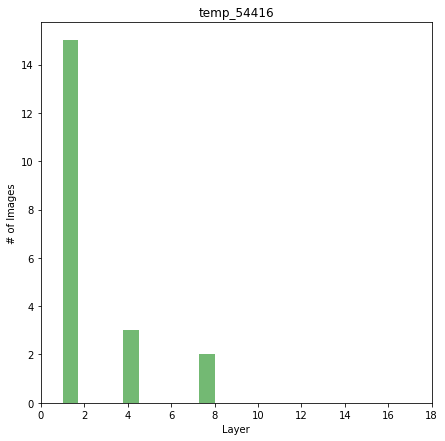

In [25]:
# plot PDs histogram
with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title(expt_name)
plt.ylabel('# of Images')
plt.xlabel('Layer')
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
# plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr],bins=10,color='g',alpha=0.55)
# plt.hist(batch_info['pd'][~correct_preds_arr ],bins=100,color='r',alpha=0.55)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

(array([15.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  2.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

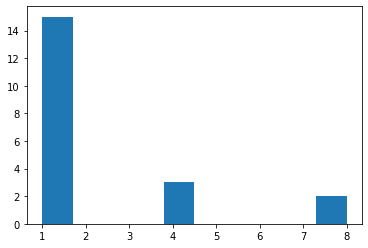

In [26]:
plt.hist(batch_info['pd'][correct_preds_arr])

# Test Model on Particular Images

In [29]:
counter = 0
total = 0
for top in tqdm([0,1,2,4,5,6,7,8,9]):
    for bot in [3]:
        for i in range(20):
            img_path = f'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_cifar10_bot_fmnist/train/top{top}_bot{bot}/{int(random.random()*1000)}.jpg'
            ckpt_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/output/temp_54416.pt'

            net = ResNet18(num_channels=num_ch)
            net = net.to(device)
            net.linear = nn.Linear(in_features=1024,out_features=10,bias=True)
            net = torch.nn.DataParallel(net)
            net.load_state_dict(torch.load(ckpt_path)['net'])
            net.eval()

            T = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize((64,32)),
            ])

            with Image.open(img_path) as im:
                out = net(T(im).unsqueeze(0))
                total+=1
                if int(out.argmax())==bot:
                    counter+=1
print(f'counter:{counter},total:{total},accuracy:{counter*100/total}')

100%|██████████| 9/9 [00:37<00:00,  4.21s/it]

counter:0,total:180,accuracy:0.0


In [ ]:
print(f'counter:{counter},total:{total}')

In [ ]:
0:48/180, 26%,21%,80%,4.5,

'temp_54416'

# Create Domino CSV Files

In [ ]:
# user hyperparams
top_dset_name = 'cifar10'
bot_dset_name = 'fmnist'
top_inds = [0,1]
bot_inds = [0,1]

In [ ]:
df = pd.DataFrame(columns=['path','bottom_label','top_label','val_train_split','test_split','all_zeros'])

# domino = 5000/800
# blank = 6000/1000
if top_dset_name=='blank':
    arr = np.arange(0,6000,1)
    np.random.shuffle(arr)
    val_arr = arr[:600]
    train_arr = arr[600:]
    num_test_imgs = 1000
else:
    arr = np.arange(0,5000,1)
    np.random.shuffle(arr)
    val_arr = arr[:500]
    train_arr = arr[500:]
    num_test_imgs = 800

for (top_idx,bot_idx) in zip(top_inds,bot_inds):
    for img_id in tqdm(train_arr):
        if top_dset_name=='blank':
            path = f'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_{top_dset_name}_bot_{bot_dset_name}/train/{bot_idx}/{img_id}.jpg'
        else:    
            path = f'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_{top_dset_name}_bot_{bot_dset_name}/train/top{top_idx}_bot{bot_idx}/{img_id}.jpg'
        df = df.append({'path':path, 'bot_lbl':bot_idx, 'top_lbl':top_idx, 'val_train_split':1, 'test_split':0, 'all_zeros':0}, ignore_index=True)
        
    for img_id in tqdm(val_arr):
        if top_dset_name=='blank':
            path = f'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_{top_dset_name}_bot_{bot_dset_name}/train/{bot_idx}/{img_id}.jpg'
        else:
            path = f'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_{top_dset_name}_bot_{bot_dset_name}/train/top{top_idx}_bot{bot_idx}/{img_id}.jpg'
        df = df.append({'path':path, 'bot_lbl':bot_idx, 'top_lbl':top_idx, 'val_train_split':0, 'test_split':0, 'all_zeros':0}, ignore_index=True)
        
    for img_id in tqdm(range(num_test_imgs)):
        if top_dset_name=='blank':            
            path = f'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_{top_dset_name}_bot_{bot_dset_name}/test/{bot_idx}/{img_id}.jpg'
        else:
            path = f'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_{top_dset_name}_bot_{bot_dset_name}/test/top{top_idx}_bot{bot_idx}/{img_id}.jpg'
        df = df.append({'path':path, 'bot_lbl':bot_idx, 'top_lbl':top_idx, 'val_train_split':2, 'test_split':1, 'all_zeros':0}, ignore_index=True)
     

In [ ]:
# csv_save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_cifar10_bot_fmnist_2class_ro1p0.csv'
# df.to_csv(csv_save_path, index=False)   